# GOOGL - Algorithmic Trading Analysis

**Generated:** 2026-02-21 11:14:49

## Overview

This notebook demonstrates a complete algorithmic trading workflow using the **algoshort** library.

### Workflow Steps:
1. **Data Acquisition** - Download historical OHLC data from Yahoo Finance
2. **Relative Price Calculation** - Calculate performance relative to FTSE MIB benchmark
3. **Signal Generation** - Generate trading signals using multiple strategies
4. **Signal Combination** - Combine signals with entry/exit/direction logic
5. **Returns Calculation** - Calculate P&L and equity curves
6. **Stop Loss Calculation** - Implement risk management
7. **Position Sizing** - Determine optimal position sizes

### Key Concepts:
- **Relative Prices**: Stock performance vs. market benchmark (isolates alpha)
- **Regime Detection**: Identify bullish/bearish market conditions
- **Signal Combination**: Use direction + entry + exit logic for robust signals

---

## Configuration

### Ticker Settings

In [1]:
# =============================================================================
# TICKER CONFIGURATION
# =============================================================================
TICKER = "GOOGL"
BENCHMARK = "^IXIC"
START_DATE = "2024-01-01"
INITIAL_CAPITAL = 10000

### Imports and Logging Setup

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================
import logging
import pandas as pd
import numpy as np
from datetime import date
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

logging.basicConfig(
    level=logging.WARNING,
    format="%(asctime)s [%(levelname)7s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

print("Imports completed successfully!")

Imports completed successfully!


---

## 1. Data Acquisition

### YFinanceDataHandler

The `YFinanceDataHandler` class provides:
- **Automatic caching** with parquet files (10-50x faster on repeated access)
- **Bulk downloads** with chunking to avoid rate limits
- **Data quality checks** and cleaning

**Key Methods:**
- `download_data()` - Download data for symbols
- `get_ohlc_data()` - Get formatted OHLC data
- `get_info()` - Get company fundamentals

In [3]:
# =============================================================================
# DATA DOWNLOAD
# =============================================================================
from algoshort.yfinance_handler import YFinanceDataHandler

handler = YFinanceDataHandler(cache_dir="./cache", enable_logging=False, chunk_size=30)

print(f"Downloading data for GOOGL and ^IXIC...")
print(f"Period: 2024-01-01 to {date.today()}")

handler.download_data(
    symbols=[TICKER, BENCHMARK],
    start=START_DATE,
    end=date.today().isoformat(),
    interval='1d',
    use_cache=True
)

print("\nDownload complete!")

Period: 2024-01-01 to 2026-02-21



Download complete!


/opt/hostedtoolcache/Python/3.11.14/x64/lib/python3.11/site-packages/yfinance/scrapers/history.py:204: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  dt_now = pd.Timestamp.utcnow()


In [4]:
# =============================================================================
# DATA QUALITY CHECK
# =============================================================================
print("Data Quality Summary:")
print("=" * 60)

summary = handler.list_available_data()
for symbol, info in summary.items():
    print(f"\n{symbol}:")
    print(f"  Rows: {info['rows']}")
    print(f"  Date Range: {info['date_range']}")
    print(f"  Missing Values: {info['missing_values']}")

Data Quality Summary:

^IXIC:
  Rows: 536
  Date Range: 2024-01-02 to 2026-02-20
  Missing Values: 0

GOOGL:
  Rows: 536
  Date Range: 2024-01-02 to 2026-02-20
  Missing Values: 0


In [5]:
# =============================================================================
# GET OHLC DATA
# =============================================================================
df = handler.get_ohlc_data(TICKER)
bmk = handler.get_ohlc_data(BENCHMARK)

# Add FX column (required for some calculations)
# Set to 1 for same currency
df['fx'] = 1

print(f"GOOGL Data Shape: {df.shape}")
print(f"^IXIC Data Shape: {bmk.shape}")
print(f"\nDate Range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"\nFirst 5 rows:")
df.head()

GOOGL Data Shape: (536, 6)
^IXIC Data Shape: (536, 5)

Date Range: 2024-01-02 to 2026-02-20

First 5 rows:


,date,open,high,low,close,fx
0,2024-01-02 00:00:00-05:00,137.511005,138.404250,135.456521,137.133850,1
1,2024-01-03 00:00:00-05:00,136.220760,138.582917,136.052037,137.878235,1
2,2024-01-04 00:00:00-05:00,137.381994,138.116450,135.327525,135.367218,1
3,2024-01-05 00:00:00-05:00,135.724498,136.131427,134.136491,134.712143,1
4,2024-01-08 00:00:00-05:00,135.267963,137.967567,135.238189,137.798843,1


In [6]:
# =============================================================================
# COMPANY INFORMATION
# =============================================================================
info = handler.get_info(TICKER)

print(f"Company: {info.get('longName', 'N/A')}")
print(f"Sector: {info.get('sector', 'N/A')}")
print(f"Industry: {info.get('industry', 'N/A')}")
print(f"Market Cap: {info.get('marketCap', 0):,.0f}")
print(f"P/E Ratio: {info.get('trailingPE', 'N/A')}")
print(f"Dividend Yield: {info.get('dividendYield', 0)*100:.2f}%" if info.get('dividendYield') else "Dividend Yield: N/A")

Company: Alphabet Inc.
Sector: Communication Services
Industry: Internet Content & Information
Market Cap: 3,810,313,371,648
P/E Ratio: 29.164816
Dividend Yield: 27.00%


/opt/hostedtoolcache/Python/3.11.14/x64/lib/python3.11/site-packages/yfinance/scrapers/quote.py:700: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  start = pd.Timestamp.utcnow().floor("D") - datetime.timedelta(days=365 // 2)
/opt/hostedtoolcache/Python/3.11.14/x64/lib/python3.11/site-packages/yfinance/scrapers/quote.py:702: Pandas4Warning: Timestamp.utcnow is deprecated and will be removed in a future version. Use Timestamp.now('UTC') instead.
  end = pd.Timestamp.utcnow().ceil("D")


---

## 2. Relative Price Calculation

### OHLCProcessor

**Why Relative Prices?**

Relative prices show how a stock performs **compared to the market**:
- **Absolute Price**: Stock goes up 5% -> Could be market rally (beta)
- **Relative Price**: Stock goes up 5% vs market 2% -> Stock outperforms (alpha)

**Calculation:**
```
Relative Price = Stock Price / Benchmark Price (rebased to 1.0)
```

In [7]:
# =============================================================================
# CALCULATE RELATIVE PRICES
# =============================================================================
from algoshort.ohlcprocessor import OHLCProcessor

processor = OHLCProcessor()
df = processor.calculate_relative_prices(
    stock_data=df,
    benchmark_data=bmk,
    benchmark_column='close',
    digits=4,
    rebase=True
)

print("Relative OHLC columns created:")
print("  ropen  - Relative Open")
print("  rhigh  - Relative High")
print("  rlow   - Relative Low")
print("  rclose - Relative Close")
print(f"\nDataFrame shape: {df.shape}")

Relative OHLC columns created:
  ropen  - Relative Open
  rhigh  - Relative High
  rlow   - Relative Low
  rclose - Relative Close

DataFrame shape: (536, 10)


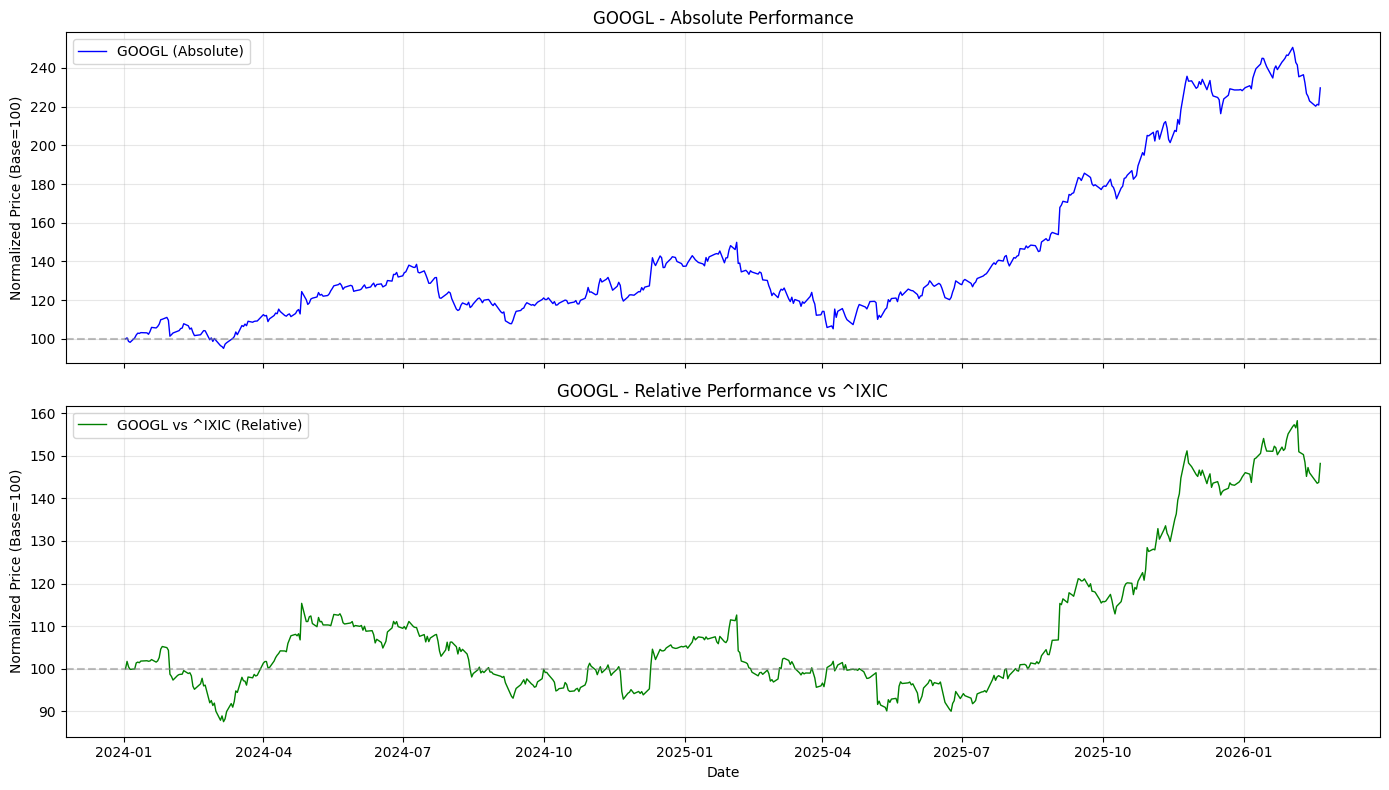


Performance Summary:
  Absolute Return: +129.69%
  Relative Return (vs benchmark): +48.19%


In [8]:
# =============================================================================
# VISUALIZE ABSOLUTE VS RELATIVE PERFORMANCE
# =============================================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

abs_normalized = (df['close'] / df['close'].iloc[0]) * 100
rel_normalized = (df['rclose'] / df['rclose'].iloc[0]) * 100

axes[0].plot(df['date'], abs_normalized, 'b-', linewidth=1, label=f'GOOGL (Absolute)')
axes[0].axhline(y=100, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylabel('Normalized Price (Base=100)')
axes[0].set_title(f'GOOGL - Absolute Performance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df['date'], rel_normalized, 'g-', linewidth=1, label=f'GOOGL vs ^IXIC (Relative)')
axes[1].axhline(y=100, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Normalized Price (Base=100)')
axes[1].set_xlabel('Date')
axes[1].set_title(f'GOOGL - Relative Performance vs ^IXIC')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

abs_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
rel_return = (df['rclose'].iloc[-1] / df['rclose'].iloc[0] - 1) * 100
print(f"\nPerformance Summary:")
print(f"  Absolute Return: {abs_return:+.2f}%")
print(f"  Relative Return (vs benchmark): {rel_return:+.2f}%")

---

## 3. Signal Generation

### Trading Signals Overview

| Method | Class | Description |
|--------|-------|-------------|
| **Breakout** | `RegimeBO` | Price breaks above/below N-day high/low |
| **Turtle Trader** | `RegimeBO` | Dual-window breakout system |
| **MA Crossover** | `TripleMACrossoverRegime` | Triple moving average alignment |
| **Floor/Ceiling** | `RegimeFC` | Swing-based regime detection |

**Signal Values:**
- `1` = Bullish / Long
- `0` = Neutral / Flat
- `-1` = Bearish / Short

In [9]:
# =============================================================================
# BREAKOUT SIGNALS
# =============================================================================
from algoshort.regime_bo import RegimeBO

regime_bo = RegimeBO(ohlc_stock=df)
breakout_windows = [20, 50, 100]

print("Generating Breakout Signals:")
print("=" * 60)

for window in breakout_windows:
    df = regime_bo.compute_regime(regime_type='breakout', window=window, relative=True, inplace=True)
    signal_col = f'rbo_{window}'
    counts = df[signal_col].value_counts().to_dict()
    print(f"\n  rbo_{window} ({window}-day breakout):")
    print(f"    Long (1):  {counts.get(1.0, 0):>5} bars ({counts.get(1.0, 0)/len(df)*100:.1f}%)")
    print(f"    Short (-1): {counts.get(-1.0, 0):>5} bars ({counts.get(-1.0, 0)/len(df)*100:.1f}%)")

Generating Breakout Signals:

  rbo_20 (20-day breakout):
    Long (1):    277 bars (51.7%)
    Short (-1):   240 bars (44.8%)

  rbo_50 (50-day breakout):
    Long (1):    282 bars (52.6%)
    Short (-1):   184 bars (34.3%)

  rbo_100 (100-day breakout):
    Long (1):    195 bars (36.4%)
    Short (-1):   170 bars (31.7%)


In [10]:
# =============================================================================
# TURTLE TRADER SIGNALS
# =============================================================================
print("\nGenerating Turtle Trader Signals:")
print("=" * 60)

df = regime_bo.compute_regime(regime_type='turtle', window=50, fast_window=20, relative=True, inplace=True)

signal_col = 'rtt_5020'
counts = df[signal_col].value_counts().to_dict()
print(f"\n  rtt_5020 (Slow=50, Fast=20):")
print(f"    Long (1):   {counts.get(1, 0):>5} bars ({counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"    Neutral (0): {counts.get(0, 0):>5} bars ({counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"    Short (-1): {counts.get(-1, 0):>5} bars ({counts.get(-1, 0)/len(df)*100:.1f}%)")


Generating Turtle Trader Signals:

  rtt_5020 (Slow=50, Fast=20):
    Long (1):     228 bars (42.5%)
    Neutral (0):   153 bars (28.5%)
    Short (-1):   155 bars (28.9%)


In [11]:
# =============================================================================
# MOVING AVERAGE CROSSOVER SIGNALS
# =============================================================================
from algoshort.regime_ma import TripleMACrossoverRegime

regime_ma = TripleMACrossoverRegime(ohlc_stock=df)
ma_params = {'short': 50, 'medium': 100, 'long': 150}

print("\nGenerating MA Crossover Signals:")
print("=" * 60)
print(f"Parameters: Short={ma_params['short']}, Medium={ma_params['medium']}, Long={ma_params['long']}")

for ma_type in ['sma', 'ema']:
    df = regime_ma.compute_ma_regime(
        ma_type=ma_type,
        short_window=ma_params['short'],
        medium_window=ma_params['medium'],
        long_window=ma_params['long'],
        relative=True,
        inplace=True
    )
    signal_col = f"r{ma_type}_{ma_params['short']}{ma_params['medium']}{ma_params['long']}"
    counts = df[signal_col].value_counts().to_dict()
    print(f"\n  {signal_col} ({ma_type.upper()}):")
    print(f"    Long (1):  {counts.get(1.0, 0):>5} bars ({counts.get(1.0, 0)/len(df)*100:.1f}%)")
    print(f"    Short (-1): {counts.get(-1.0, 0):>5} bars ({counts.get(-1.0, 0)/len(df)*100:.1f}%)")


Generating MA Crossover Signals:
Parameters: Short=50, Medium=100, Long=150

  rsma_50100150 (SMA):
    Long (1):    249 bars (46.5%)
    Short (-1):   138 bars (25.7%)

  rema_50100150 (EMA):
    Long (1):    347 bars (64.7%)
    Short (-1):    40 bars (7.5%)


In [12]:
# =============================================================================
# FLOOR/CEILING REGIME DETECTION
# =============================================================================
from algoshort.regime_fc import RegimeFC

regime_fc = RegimeFC(df=df, log_level=logging.WARNING)

print("\nGenerating Floor/Ceiling Regime:")
print("=" * 60)

df = regime_fc.compute_regime(
    relative=True, lvl=3, vlty_n=63, threshold=0.05,
    dgt=3, d_vol=1, dist_pct=0.05, retrace_pct=0.05, r_vol=1.0
)

if 'rrg' in df.columns:
    counts = df['rrg'].value_counts().to_dict()
    print(f"\n  rrg (Floor/Ceiling Regime):")
    print(f"    Bullish (1):  {counts.get(1.0, 0):>5} bars ({counts.get(1.0, 0)/len(df)*100:.1f}%)")
    print(f"    Bearish (-1): {counts.get(-1.0, 0):>5} bars ({counts.get(-1.0, 0)/len(df)*100:.1f}%)")

# Also compute absolute regime
df = regime_fc.compute_regime(
    relative=False, lvl=3, vlty_n=63, threshold=0.05,
    dgt=3, d_vol=1, dist_pct=0.05, retrace_pct=0.05, r_vol=1.0
)

2026-02-21 11:15:48,802 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop


2026-02-21 11:15:48 [WARNING] algoshort.regime_fc.RegimeFC: No peaks found, breaking loop


2026-02-21 11:15:48,840 - algoshort.regime_fc.RegimeFC - WARNING - No peaks found, breaking loop


2026-02-21 11:15:48 [WARNING] algoshort.regime_fc.RegimeFC: No peaks found, breaking loop



Generating Floor/Ceiling Regime:

  rrg (Floor/Ceiling Regime):
    Bullish (1):    118 bars (22.0%)
    Bearish (-1):   101 bars (18.8%)


In [13]:
# =============================================================================
# SIGNAL SUMMARY
# =============================================================================
_ma_intermediates = [
    'rsma_50100', 'rsma_100150',
    'rema_50100', 'rema_100150'
]
signal_columns = [col for col in df.columns
    if any(col.startswith(prefix) for prefix in ['rbo_', 'rtt_', 'rsma_', 'rema_', 'rrg'])
    and not any(kw in col for kw in ['short', 'medium', 'long', '_ch'])
    and col not in _ma_intermediates]
signal_columns = [x for x in signal_columns if x != 'rrg_ch']

print(f"\nTotal Signals Generated: {len(signal_columns)}")
print("=" * 60)
for sig in signal_columns:
    print(f"  * {sig}")


Total Signals Generated: 7
  * rbo_20
  * rbo_50
  * rbo_100
  * rtt_5020
  * rsma_50100150
  * rema_50100150
  * rrg


---

## 4. Signal Combination

### Grid Search

**Why Combine Signals?**

Individual signals can be noisy. Combining them provides:
- **Direction Filter**: Only trade in direction of overall trend (floor/ceiling)
- **Entry Timing**: Use momentum signals for entry timing
- **Exit Timing**: Use different signal for exit

In [14]:
# =============================================================================
# GRID SEARCH - TEST ALL COMBINATIONS
# =============================================================================
from algoshort.combiner import SignalGridSearch

direction_col = 'rrg'
entry_exit_signals = [x for x in signal_columns if x != direction_col]

print("Running Grid Search (All Entry/Exit Combinations):")
print("=" * 60)

searcher = SignalGridSearch(
    df=df.copy(),
    available_signals=entry_exit_signals,
    direction_col=direction_col
)

results = searcher.run_grid_search_parallel(
    allow_flips=True,
    require_regime_alignment=True,
    n_jobs=-1,
    backend='multiprocessing'
)

df = searcher.df

Running Grid Search (All Entry/Exit Combinations):
✓ Validation passed: All 6 signals found in dataframe

GRID GENERATION
Direction column: rrg
Available signals for entry/exit: 6
Signals: ['rbo_20', 'rbo_50', 'rbo_100', 'rtt_5020', 'rsma_50100150', 'rema_50100150']

Total combinations to test: 36
  = 6 entry signals × 6 exit signals

RUNNING PARALLEL GRID SEARCH
Direction column: rrg
Allow flips: True
Require regime alignment: True
Backend: multiprocessing
Parallel jobs: 4 cores

Processing 36 combinations in parallel...


Testing combinations:   0%|          | 0/36 [00:00<?, ?it/s]

Testing combinations:   3%|▎         | 1/36 [00:03<02:01,  3.48s/it]

Testing combinations: 100%|██████████| 36/36 [00:03<00:00, 10.34it/s]


Adding combined signal columns to main dataframe...

GRID SEARCH COMPLETE
Successful combinations: 36
Failed combinations: 0


In [15]:
# =============================================================================
# UPDATE SIGNAL COLUMNS WITH COMBINED SIGNALS
# =============================================================================
# Add grid search combined signals to signal_columns
# so they are processed through returns, stop loss, and position sizing
signal_columns = results.output_column.tolist() + signal_columns

In [16]:
# =============================================================================
# GRID SEARCH RESULTS
# =============================================================================
print("\nGrid Search Results:")
print("=" * 60)
print(f"Total Combinations Tested: {len(results)}")
print(f"Successful: {results['success'].sum()}")
print(f"Failed: {(~results['success']).sum()}")

print("\nTop 10 Most Active Combinations:")
top_results = results.nlargest(10, 'total_trades')[[
    'combination_name', 'total_trades', 'long_trades', 'short_trades', 'long_pct', 'short_pct'
]]
print(top_results.to_string(index=False))


Grid Search Results:
Total Combinations Tested: 36
Successful: 36
Failed: 0

Top 10 Most Active Combinations:
            combination_name  total_trades  long_trades  short_trades  long_pct  short_pct
      rbo_100__rema_50100150            46            1            45 21.828358  10.447761
       rbo_50__rema_50100150            38            1            37 22.014925   6.902985
       rbo_20__rema_50100150            36            1            35 22.014925   6.529851
      rbo_100__rsma_50100150            36            6            29 20.895522  13.432836
     rtt_5020__rema_50100150            36            1            35 22.014925   6.529851
             rbo_100__rbo_20            29           14            15 19.402985  15.485075
       rbo_50__rsma_50100150            25            7            18 20.895522  10.261194
       rbo_20__rsma_50100150            24            7            17 20.895522   9.888060
     rtt_5020__rsma_50100150            24            7            17 

---

## 5. Returns Calculation

### ReturnsCalculator

**Calculates for each signal:**
- `{signal}_chg1D`: Daily price change x position
- `{signal}_PL_cum`: Cumulative P&L
- `{signal}_returns`: Percentage returns
- `{signal}_cumul`: Cumulative returns

In [17]:
# =============================================================================
# CALCULATE RETURNS
# =============================================================================
from algoshort.returns import ReturnsCalculator

returns_calc = ReturnsCalculator(
    ohlc_stock=df,
    open_col="open", high_col="high", low_col="low", close_col="close",
    relative_prefix="r"
)

print("Calculating Returns for All Signals:")
print("=" * 60)

df = returns_calc.get_returns_multiple(df=df, signals=signal_columns, relative=True, n_jobs=-1, verbose=False)

print(f"\nReturn columns created for {len(signal_columns)} signals")

Calculating Returns for All Signals:



Return columns created for 43 signals


In [18]:
# =============================================================================
# RETURNS SUMMARY
# =============================================================================
print("\nCumulative Returns by Signal:")
print("=" * 60)

cumul_returns = {}
for sig in signal_columns:
    cumul_col = f'{sig}_cumul'
    if cumul_col in df.columns:
        cumul_returns[sig] = df[cumul_col].iloc[-1] * 100

sorted_returns = sorted(cumul_returns.items(), key=lambda x: x[1], reverse=True)

for sig, ret in sorted_returns:
    print(f"  {sig}: {ret:+.2f}%")


Cumulative Returns by Signal:
  rsma_50100150: +39.31%
  rbo_50__rbo_20: +35.95%
  rbo_50__rbo_50: +33.26%
  rbo_50__rtt_5020: +33.26%
  rbo_20__rema_50100150: +32.66%
  rtt_5020__rema_50100150: +32.66%
  rbo_50__rsma_50100150: +32.04%
  rbo_20__rbo_50: +30.31%
  rbo_20__rtt_5020: +30.31%
  rtt_5020__rbo_50: +30.31%
  rtt_5020__rtt_5020: +30.31%
  rbo_20: +29.96%
  rbo_100__rbo_20: +28.59%
  rbo_20__rbo_20: +27.82%
  rtt_5020__rbo_20: +27.82%
  rbo_20__rsma_50100150: +27.59%
  rtt_5020__rsma_50100150: +27.59%
  rtt_5020: +27.54%
  rbo_50__rema_50100150: +27.52%
  rema_50100150__rbo_20: +27.31%
  rema_50100150__rbo_50: +27.15%
  rema_50100150__rtt_5020: +27.15%
  rbo_50: +25.49%
  rbo_100__rbo_50: +23.89%
  rbo_100__rtt_5020: +23.89%
  rbo_50__rbo_100: +22.55%
  rema_50100150: +22.14%
  rsma_50100150__rsma_50100150: +20.96%
  rbo_20__rbo_100: +19.84%
  rbo_100__rbo_100: +19.84%
  rtt_5020__rbo_100: +19.84%
  rbo_100__rema_50100150: +15.51%
  rbo_100: +14.90%
  rsma_50100150__rbo_20: +1

---

## 6. Stop Loss Calculation

### StopLossCalculator

**Available Methods:**
| Method | Description |
|--------|-------------|
| `atr_stop_loss` | ATR-based (volatility-adjusted) |
| `fixed_percentage_stop_loss` | Fixed % below/above entry |
| `breakout_channel_stop_loss` | N-day high/low |
| `moving_average_stop_loss` | MA-based stops |

In [19]:
# =============================================================================
# CALCULATE STOP LOSSES
# =============================================================================
from algoshort.stop_loss import StopLossCalculator

sl_calc = StopLossCalculator(df)

print("Calculating ATR-Based Stop Losses:")
print("=" * 60)

for signal in signal_columns:
    df = sl_calc.atr_stop_loss(signal=signal, window=14, multiplier=2.5)
    sl_calc.data = df

sl_cols = [col for col in df.columns if col.endswith('_stop_loss')]
print(f"\nStop loss columns created: {len(sl_cols)}")

Calculating ATR-Based Stop Losses:



Stop loss columns created: 43


---

## 7. Position Sizing

### PositionSizing

**Position Sizing Strategies:**

| Strategy | Description | Risk Profile |
|----------|-------------|-------------|
| `equal_weight` | Fixed % of capital | Moderate |
| `constant` | Fixed risk per trade | Moderate |
| `concave` | Reduce risk as drawdown increases | Conservative |
| `convex` | Increase risk when winning | Aggressive |

In [20]:
# =============================================================================
# POSITION SIZING
# =============================================================================
from algoshort.position_sizing import PositionSizing, run_position_sizing_parallel

sizer = PositionSizing(
    tolerance=-0.35, mn=0.25, mx=0.6,
    equal_weight=0.1, avg=0.06, lot=1,
    initial_capital=INITIAL_CAPITAL
)

print(f"Position Sizing Configuration:")
print("=" * 60)
print(f"  Initial Capital: {INITIAL_CAPITAL:,}")
print(f"  Equal Weight: {int(0.1 * 100)}% per position")
print(f"  Risk Range: {int(abs(0.25) * 100)}% - {int(abs(0.6) * 100)}% per trade")
print(f"  Max Drawdown Tolerance: {int(abs(-0.35) * 100)}%")

print("\nCalculating Position Sizes...")

df = run_position_sizing_parallel(
    sizer=sizer, df=df, signals=signal_columns,
    chg_suffix="_chg1D_fx", sl_suffix="_stop_loss",
    close_col='close', n_jobs=-1, verbose=5
)

Position Sizing Configuration:
  Initial Capital: 10,000
  Equal Weight: 10% per position
  Risk Range: 25% - 60% per trade
  Max Drawdown Tolerance: 35%

Calculating Position Sizes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s


[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:   15.3s finished


In [21]:
# =============================================================================
# EQUITY CURVE ANALYSIS
# =============================================================================
print("\nEquity Curve Summary:")
print("=" * 60)

# Find all equity columns (equal, constant, concave, convex)
equity_cols = [col for col in df.columns if '_equity_' in col]

equity_results = []
for col in equity_cols:
    final_equity = df[col].iloc[-1]
    total_return = (final_equity / INITIAL_CAPITAL - 1) * 100
    max_equity = df[col].max()
    max_drawdown = (df[col].min() - max_equity) / max_equity * 100
    equity_results.append({
        'equity_signal': col,
        'Final Equity': final_equity,
        'Total Return': total_return,
        'Max Drawdown': max_drawdown
    })

equity_df = pd.DataFrame(equity_results).sort_values('Final Equity', ascending=False)
equity_df['combination_name'] = equity_df['equity_signal'].str.replace(r'_equity.*$', '', regex=True)
equity_df = equity_df.merge(results[['combination_name', 'total_trades']], on='combination_name', how='left').sort_values('Final Equity', ascending=False).reset_index(drop=True)

# Create 'Signal' column using clean combination name (no position-sizing suffix)
equity_df['Signal'] = equity_df['combination_name']

print(equity_df.head(20).to_string(index=False))


Equity Curve Summary:
                         equity_signal  Final Equity  Total Return  Max Drawdown        combination_name  total_trades                  Signal
         rbo_50__rbo_20_equity_concave    39531.1363    295.311363    -76.148046          rbo_50__rbo_20          16.0          rbo_50__rbo_20
         rbo_50__rbo_50_equity_concave    28704.9599    187.049599    -70.390920          rbo_50__rbo_50           2.0          rbo_50__rbo_50
       rbo_50__rtt_5020_equity_concave    28704.9599    187.049599    -70.390920        rbo_50__rtt_5020           2.0        rbo_50__rtt_5020
          rbo_50__rbo_20_equity_convex    27365.6749    173.656749    -66.283373          rbo_50__rbo_20          16.0          rbo_50__rbo_20
         rbo_20__rbo_20_equity_concave    26206.8909    162.068909    -65.646448          rbo_20__rbo_20           4.0          rbo_20__rbo_20
       rtt_5020__rbo_20_equity_concave    26206.8909    162.068909    -65.646448        rtt_5020__rbo_20           4.0 

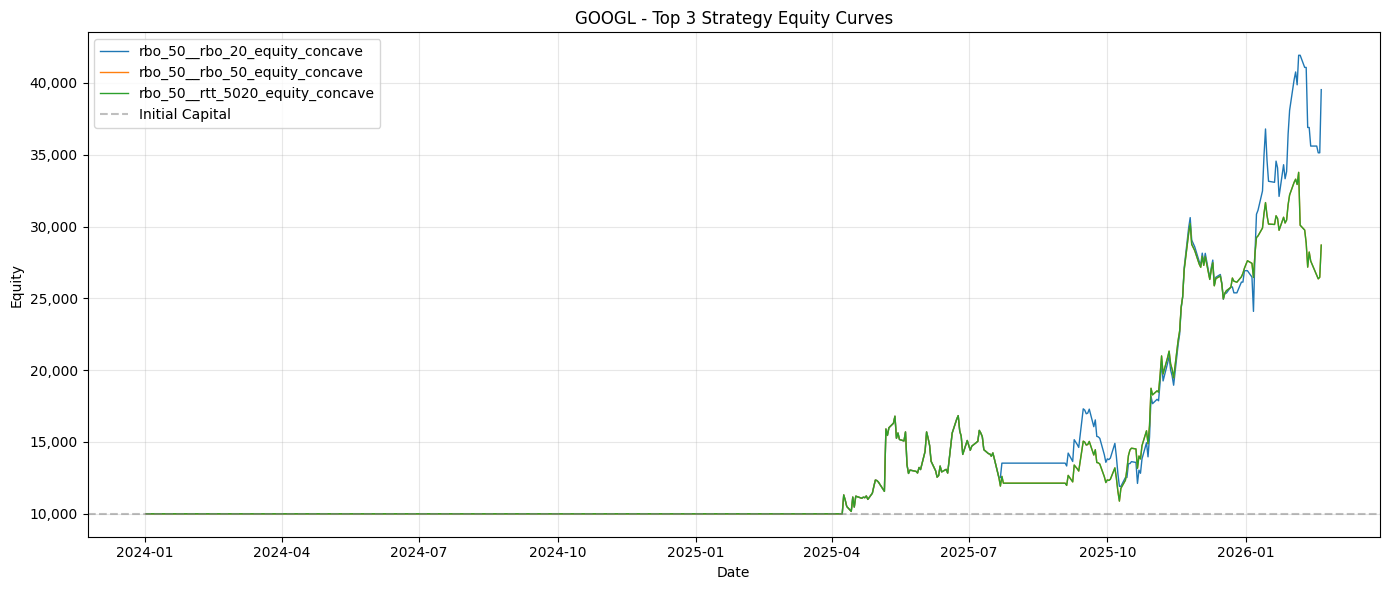

In [22]:
# =============================================================================
# VISUALIZE EQUITY CURVES
# =============================================================================
top_signals = equity_df.head(3)['equity_signal'].tolist()

fig, ax = plt.subplots(figsize=(14, 6))

for equity_col in top_signals:
    if equity_col in df.columns:
        ax.plot(df['date'], df[equity_col], label=equity_col, linewidth=1)

ax.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

ax.set_xlabel('Date')
ax.set_ylabel('Equity')
ax.set_title(f'GOOGL - Top 3 Strategy Equity Curves')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

---

## 8. Final Summary

### Complete Analysis Results

In [23]:
# =============================================================================
# FINAL SUMMARY
# =============================================================================
print("=" * 70)
print(f"FINAL ANALYSIS SUMMARY - GOOGL")
print("=" * 70)

print(f"\n1. DATA:")
print(f"   Ticker: GOOGL")
print(f"   Benchmark: ^IXIC")
print(f"   Period: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")
print(f"   Trading Days: {len(df):,}")

abs_return = (df['close'].iloc[-1] / df['close'].iloc[0] - 1) * 100
rel_return = (df['rclose'].iloc[-1] / df['rclose'].iloc[0] - 1) * 100
print(f"\n2. BUY & HOLD PERFORMANCE:")
print(f"   Absolute Return: {abs_return:+.2f}%")
print(f"   Relative Return (vs ^IXIC): {rel_return:+.2f}%")

best_strategy = equity_df.iloc[0]
print(f"\n3. BEST STRATEGY:")
print(f"   Signal: {best_strategy['equity_signal']}")
print(f"   Total Return: {best_strategy['Total Return']:+.2f}%")
print(f"   Final Equity: {best_strategy['Final Equity']:,.0f}")

print(f"\n4. DATAFRAME:")
print(f"   Shape: {df.shape}")
print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

ohlc_cols = len([c for c in df.columns if c in ['date', 'open', 'high', 'low', 'close', 'fx']])
rel_cols = len([c for c in df.columns if c.startswith('r') and c[1:] in ['open', 'high', 'low', 'close']])
signal_cols_count = len(signal_columns)
return_cols = len([c for c in df.columns if any(k in c for k in ['_chg1D', '_PL_cum', '_returns', '_cumul'])])
sl_cols_count = len([c for c in df.columns if '_stop_loss' in c])
equity_cols_count = len([c for c in df.columns if '_equity_' in c])

print(f"\n5. COLUMNS BREAKDOWN:")
print(f"   OHLC: {ohlc_cols}")
print(f"   Relative OHLC: {rel_cols}")
print(f"   Signals: {signal_cols_count}")
print(f"   Returns: {return_cols}")
print(f"   Stop Losses: {sl_cols_count}")
print(f"   Equity Curves: {equity_cols_count}")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE!")
print("=" * 70)

FINAL ANALYSIS SUMMARY - GOOGL

1. DATA:
   Ticker: GOOGL
   Benchmark: ^IXIC
   Period: 2024-01-02 to 2026-02-20
   Trading Days: 536

2. BUY & HOLD PERFORMANCE:
   Absolute Return: +129.69%
   Relative Return (vs ^IXIC): +48.19%

3. BEST STRATEGY:
   Signal: rbo_50__rbo_20_equity_concave
   Total Return: +295.31%
   Final Equity: 39,531

4. DATAFRAME:
   Shape: (536, 864)
   Memory Usage: 3.53 MB

5. COLUMNS BREAKDOWN:
   OHLC: 6
   Relative OHLC: 4
   Signals: 43
   Returns: 301
   Stop Losses: 43
   Equity Curves: 172

ANALYSIS COMPLETE!


In [24]:
# =============================================================================
# EXPORT RESULTS
# =============================================================================
import os

output_dir = "results/nasdaq"
os.makedirs(output_dir, exist_ok=True)

# Export equity summary
equity_df.to_csv(f"{output_dir}/{TICKER.replace('.', '_')}_equity.csv", index=False)

# Export latest signals
latest = df.tail(1)[['date'] + signal_columns].copy()
latest['ticker'] = TICKER
latest.to_csv(f"{output_dir}/{TICKER.replace('.', '_')}_signals.csv", index=False)

# Export grid search results
results.to_csv(f"{output_dir}/{TICKER.replace('.', '_')}_grid_search.csv", index=False)

print(f"Results exported to {output_dir}/")
print(f"  - {TICKER.replace('.', '_')}_equity.csv")
print(f"  - {TICKER.replace('.', '_')}_signals.csv")
print(f"  - {TICKER.replace('.', '_')}_grid_search.csv")

Results exported to results/nasdaq/
  - GOOGL_equity.csv
  - GOOGL_signals.csv
  - GOOGL_grid_search.csv
